# Optimisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PortfolioToolboxQP.PortfolioToolboxQP.Qp_Solver import qp_solver_cpp as solve

Il faut remplir le code suivant avec ce qu'on a calculé dans les autres fichiers. Faut juste faire attention à ce qu'on est les mêmes colonnes pour tous sinon on va avoir des problèmes de dimensions.

## Imports

In [55]:
sigma = np.load("data/cov_matrix_sigma.npy")
CI = pd.read_csv("data/CarbonIntensity.csv")
CI0 = CI["CARBON_EMISSIONS_SCOPE_12_FY23"].values.reshape(-1, 1)
Green = CI["CT_TOTAL_MAX_REV"].values.reshape(-1, 1)
bench = (CI["Weight"].values / CI["Weight"].sum()).reshape(-1, 1)


## Optimisation

### Problème à écrire

J'ai pris le problème le plus simple avec le moins de contrainte (min 1/2(x-b)Tsigma(x-b) avec comme contraintes la carbone intensity, et le bail C0 des long only constraints [x entre 0 et 1 et qui se somme à 1])

x is what we want : here the relative weights on the differents firms. The following Y is what we call "x-b". 
 We have to add the benchmark at the end

                            minimize 0.5*Y.T@Q@Y + p@Y under constraints AY = B and GY <= h and  lb <= Y <= ub
    
    all parameters are ndarray

    Q: sigma for us
    p: -lambda*Green

    CI*(X=Y+b) <= (1-R)CI_0*b donc CI*Y <= (1-R)*CI_0*b - CI*b
    G*X >= (1+g)G_0*b 
    CM*X <= CMstar
    G: Matrix of inequalty constraints 
    h: Vector of inequality constraints 

    1.T(Y+b)=1 donc 1TY = - 1Tb + 1
    A: Matrix of equality constraints → 1T
    b: Vector of equality constraints → -1Tb + 1
    
    lb: Lower bound for Y : for x : 0
    ub: Upper bound for Y : for x : 1

    return: optimal vector if found : Y=X-b

### Calcul du réduction rate 

In [8]:
def decarbonization_pathway(t0, t, Rm, dR):
    """
    Compute the decarbonization budget with equation (1).

    param t0: base year
    param t: year index
    param Rm: minimum carbon intensity reduction
    param dR: year-to-year self decarbonization on average per annum
    """
    return 1 - (1 - dR) ** (t - t0) * (1 - Rm)

### Optimisation avec pour contraintes le carbon momentum, la greenness et les émissions carbone

In [62]:
t = 2023
# PAB label: Rm=0.5 dr=0.07
R = 0.3
# Greenness evolution
g = 1
# CM* = 7%
CMstar = np.zeros(1)
CMstar[0]=-0.07

x_list = []
te = []

CM_col = "CARBON_MOMENTUM_SCOPE_12_FY23"
CM0 = CI[CM_col].values.reshape(-1, 1)


lambdas = np.linspace(8e-9,3e-8,20)

for l in lambdas:
    print(l)
    y = solve(
        Q = sigma,
        p = -l*Green,
        G = np.concatenate((CI0, -Green, CM0), axis=1).T,
        h = np.concatenate(((1 - R)*CI0.T@bench-CI0.T@bench,-g*Green.T@bench, CMstar-CM0.T@bench),axis=0),
        A = np.ones((bench.shape[0],1)).T,
        b = -np.ones(bench.shape).T @ bench + 1,
        lb = - bench,
        ub =np.ones(bench.shape) - bench,
    )
    y = y[:,np.newaxis]
    x = y + bench
    x_list.append(x)
    name_col = "Weight_lambda_"+str(l)
    CI[name_col] = x
    tracking_error = 0.5 * y.T @ sigma @ y
    te.append(tracking_error)

8e-09


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


9.157894736842106e-09


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.031578947368421e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.1473684210526316e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.2631578947368422e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.3789473684210526e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.4947368421052633e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.6105263157894735e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.726315789473684e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.8421052631578947e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.957894736842105e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.0736842105263158e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.189473684210526e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.305263157894737e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.4210526315789472e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.5368421052631574e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.6526315789473684e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.7684210526315786e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


2.8842105263157895e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


3e-08


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


In [63]:
# Convert the list of tracking errors to a numpy array for easier manipulation
te_array = [np.sqrt(te[i][0][0])*1e4 for i in range(len(te))]
greenness = [(Green.T @ x)[0][0] for x in x_list]

# Create a DataFrame to display the values
tracking_error_df = pd.DataFrame({
    'Lambda': lambdas,
    'Tracking Error': te_array,
    'Greenness': greenness
})

# Display the DataFrame
print(tracking_error_df)

          Lambda  Tracking Error  Greenness
0   8.000000e-09        2.471057  19.867561
1   9.157895e-09        2.471057  19.867561
2   1.031579e-08        2.471057  19.867561
3   1.147368e-08        2.471057  19.867561
4   1.263158e-08        2.625942  20.512917
5   1.378947e-08        2.849746  21.440653
6   1.494737e-08        3.071925  22.356415
7   1.610526e-08        3.292258  23.259619
8   1.726316e-08        3.511255  24.152724
9   1.842105e-08        3.727985  25.032147
10  1.957895e-08        3.942938  25.900033
11  2.073684e-08        4.154696  26.750774
12  2.189474e-08        4.363280  27.584375
13  2.305263e-08        4.568841  28.401455
14  2.421053e-08        4.771987  29.204479
15  2.536842e-08        4.973373  29.996233
16  2.652632e-08        5.171898  30.772510
17  2.768421e-08        5.367738  31.534081
18  2.884211e-08        5.559751  32.276522
19  3.000000e-08        5.750214  33.008740


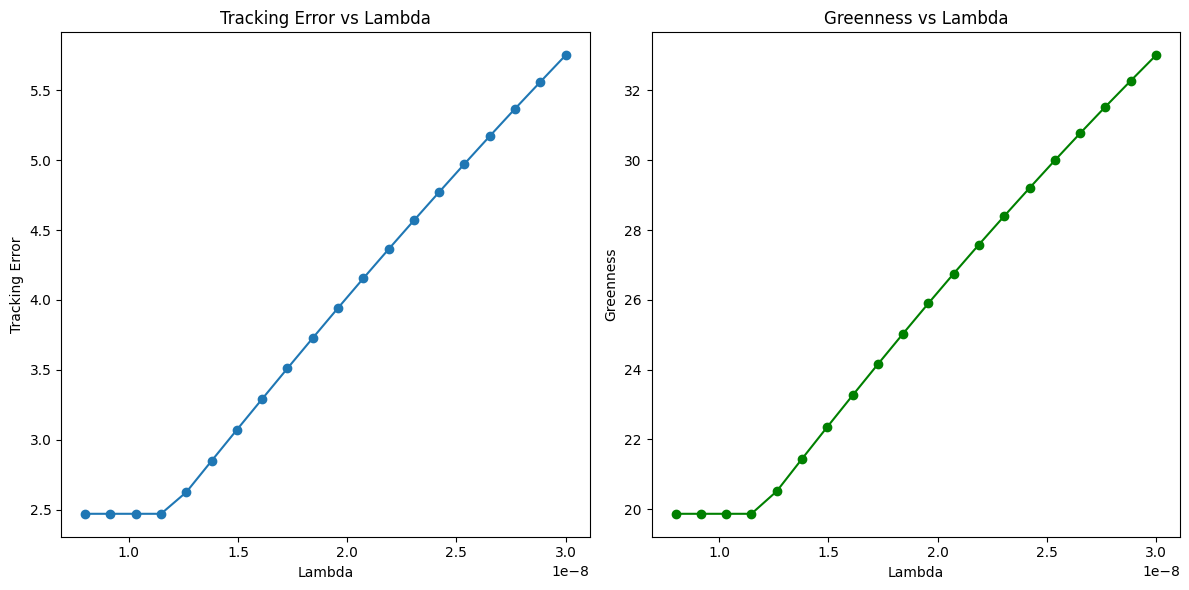

In [64]:
# Plotting the tracking error vs lambda
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lambdas, te_array, marker='o')
plt.title('Tracking Error vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Tracking Error')

# Plotting the greenness vs lambda
plt.subplot(1, 2, 2)
plt.plot(lambdas, greenness, marker='o', color='green')
plt.title('Greenness vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Greenness')

plt.tight_layout()
plt.show()

## En fonction de l'année

In [4]:
def decarbonization_pathway(t0, t, Rm, dR):
    return 1 - (1 - dR) ** (t - t0) * (1 - Rm)
t0, t = 2023, 2040
times = np.arange(t0, t + 1)
# PAB label: Rm=0.5 dr=0.07
R_ = decarbonization_pathway(t0, times, 0.5, 0.07)
# Greenness evolution
g = 1
# CM* = 7%
CMstar = np.zeros(1)
CMstar[0]=-0.07

x_list_year = []
te_year = []

lambdas = np.linspace(8e-9,3e-8,17)

for l in lambdas:
    x_list_ = []
    te_ = []
    print(l)
    for year in range(len(R_)):
        R = R_[year]
        ye = 23+year
        column_CE = "CARBON_EMISSIONS_SCOPE_12_FY"+str(ye)
        CI_year = CI[column_CE].values.reshape(-1, 1)
        column_CM = "CARBON_MOMENTUM_SCOPE_12_FY"+str(ye)
        CM_year = CI[column_CM].values.reshape(-1, 1)
        CI_year[CI_year < 0] = 0
        y = solve(
            Q = sigma,
            p = -l*Green,
            G = np.concatenate((CI_year, -Green, CM_year), axis=1).T,
            h = np.concatenate(((1 - R)*CI0.T@bench-CI_year.T@bench,-g*Green.T@bench, CMstar-CM_year.T@bench),axis=0),
            A = np.ones((bench.shape[0],1)).T,
            b = -np.ones(bench.shape).T @ bench + 1,
            lb = - bench,
            ub =np.ones(bench.shape) - bench,
        )
        y = y[:,np.newaxis]
        x = y + bench
        x_list_.append(x)
        name_col = "Weight_G_FY"+str(ye)
        CI[name_col] = x
        tracking_error = 0.5 * y.T @ sigma @ y
        te_.append(tracking_error)
    x_list_year.append(x_list_)
    te_year.append(te_)

8e-09


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  

9.375e-09


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.075e-08
1.2125000000000001e-08
1.35e-08
1.4875e-08
1.625e-08
1.7625e-08
1.8999999999999998e-08
2.0375000000000002e-08
2.175e-08
2.3124999999999997e-08
2.45e-08
2.5875e-08
2.7249999999999996e-08
2.8625e-08
3e-08


(17, 18)
(17, 18)


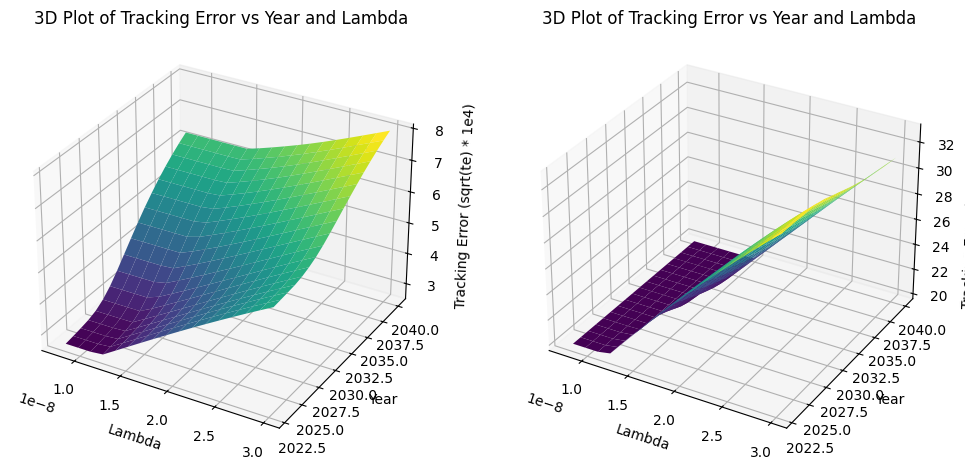

In [15]:
from mpl_toolkits.mplot3d import Axes3D
lambdas = np.linspace(8e-9,3e-8,17)
te_plot = [[np.sqrt(te_year[i][j][0][0])*1e4 for j in range(len(te_year[i]))] for i in range(len(te_year))]
te_plot = np.array(te_plot).squeeze()
print(te_plot.shape)

green_plot = [[(Green.T @ x)[0][0] for x in x_list_year[i]] for i in range(len(x_list_year))]
green_plot = np.array(green_plot).squeeze()
print(green_plot.shape)

# Create a meshgrid for the years and lambdas
t0=2023
t = 2040
years = np.arange(t0, t + 1)
lambdas_grid, years_grid = np.meshgrid(lambdas, years)

# Plotting the 3D plot
fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(121, projection='3d')

# Plot the surface
ax1.plot_surface(lambdas_grid, years_grid, te_plot.T, cmap='viridis')

# Add labels and title
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Year')
ax1.set_zlabel('Tracking Error (sqrt(te) * 1e4)')
ax1.set_title('3D Plot of Tracking Error vs Year and Lambda')

ax2 = fig.add_subplot(122, projection='3d')

# Plot the surface
ax2.plot_surface(lambdas_grid, years_grid, green_plot.T, cmap='viridis')

# Add labels and title
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Year')
ax2.set_zlabel('Tracking Error (sqrt(te) * 1e4)')
ax2.set_title('3D Plot of Tracking Error vs Year and Lambda')

plt.show()

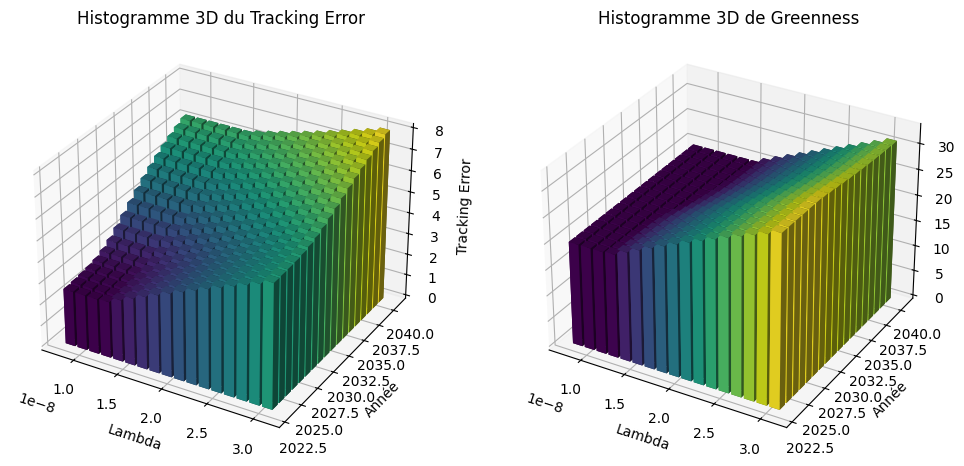

In [16]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Positions des barres en 3D
xpos, ypos = np.meshgrid(lambdas, years)  # Création des grilles pour lambda et année
xpos = xpos.flatten()  # Aplatir en liste de coordonnées
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)  # Base des barres (z=0)

# Largeur et profondeur des barres
dx = np.abs(np.diff(lambdas).mean()) * 0.8  # Ajuste la largeur des barres
dy = np.abs(np.diff(years).mean()) * 0.8  

# Hauteur des barres (valeurs de `te_year_array`)
dz1 = te_plot.T.flatten()
dz2 = green_plot.T.flatten()

# Coloration basée sur la hauteur des barres
colors1 = plt.cm.viridis((dz1 - dz1.min()) / (dz1.max() - dz1.min()))
colors2 = plt.cm.viridis((dz2 - dz2.min()) / (dz2.max() - dz2.min()))

# Création de l'histogramme 3D
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz1, color=colors1, shade=True)
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz2, color=colors2, shade=True)

# Labels et titre
ax1.set_xlabel("Lambda")
ax1.set_ylabel("Année")
ax1.set_zlabel("Tracking Error")
ax1.set_title("Histogramme 3D du Tracking Error")
ax2.set_xlabel("Lambda")
ax2.set_ylabel("Année")
ax2.set_zlabel("Greenness")
ax2.set_title("Histogramme 3D de Greenness")

plt.show()


In [5]:
t0, t = 2023, 2050
times = np.arange(t0, t + 1)
# CTB label: Rm=0.3 dR=0.07
ctb_label = decarbonization_pathway(t0, times, 0.3, 0.07)
# PAB label: Rm=0.5 dr=0.07
pab_label = decarbonization_pathway(t0, times, 0.5, 0.07)
# Greenness evolution
g = 1
# CM* = 7%
CMstar = np.zeros(1)
CMstar[0]=-0.07

x_list_green = []
te_green = []
R_ = pab_label

for year in range(len(R_)):
    R = R_[year]
    ye = 23+year
    print(ye)
    column_CE = "CARBON_EMISSIONS_SCOPE_12_FY"+str(ye)
    CI_year = CI[column_CE].values.reshape(-1, 1)
    column_CM = "CARBON_MOMENTUM_SCOPE_12_FY"+str(ye)
    CM_year = CI[column_CM].values.reshape(-1, 1)
    CI_year[CI_year < 0] = 0
    y = solve(
        Q = sigma,
        p = None,
        G = np.concatenate((CI_year, -Green, CM_year), axis=1).T,#CI0 -Gt CM
        h = np.concatenate(((1 - R)*CI0.T@bench-CI_year.T@bench,-g*Green.T@bench, CMstar-CM_year.T@bench),axis=0),# (1-R)CI0b-CItb   -(1+g)G0b-Gtb    CM*-CMb
        A = np.ones((bench.shape[0],1)).T,
        b = -np.ones(bench.shape).T @ bench + 1,
        lb = - bench,
        ub =np.ones(bench.shape) - bench,
    )
    y = y[:,np.newaxis]
    x = y + bench
    x_list_green.append(x)
    name_col = "Weight_G_FY"+str(ye)
    CI[name_col] = x
    tracking_error = 0.5 * y.T @ sigma @ y
    te_green.append(tracking_error)

23


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(


24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


43


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


44


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


45


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


46


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


47


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


48


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


49


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


50


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


[0.0003327  0.00011051 0.00027912 ... 0.01589499 0.00055802 0.00048274]


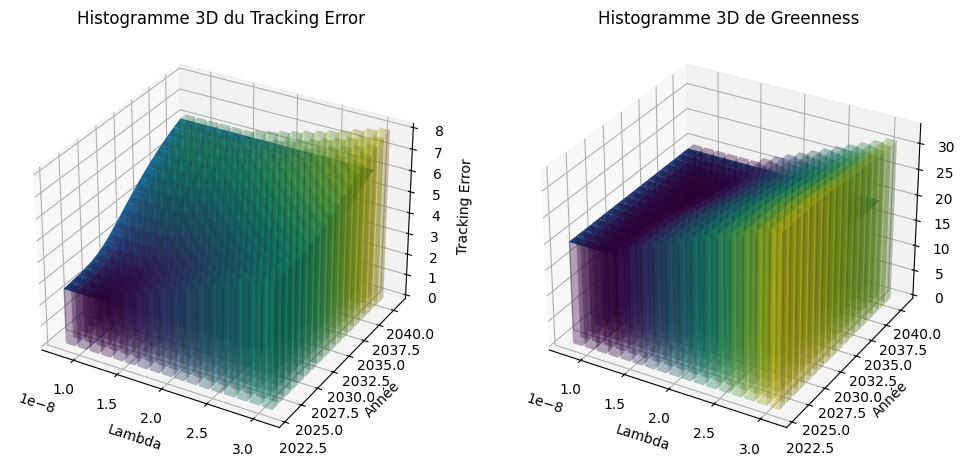

In [91]:
te_plot_green = [[np.sqrt(te_green[j][0][0])*1e4 for j in range(len(te_year[0]))] for i in range(len(te_year))]
te_plot_green = np.array(te_plot_green).squeeze()
print(x_list_green[0])
x_list_green = np.array(x_list_green).squeeze()
green_plot_ = [[(Green.T)@(x_list_green[i]) for i in range(len(te_year[0]))] for j in range(len(x_list_year))]
green_plot_ = np.array(green_plot_).squeeze()

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Création de l'histogramme 3D
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz1, color=colors1, shade=True, alpha = 0.2)
ax1.plot_surface(lambdas_grid, years_grid, te_plot_green.T)
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz2, color=colors2, shade=True, alpha = 0.2)
ax2.plot_surface(lambdas_grid, years_grid, green_plot_.T)

# Labels et titre
ax1.set_xlabel("Lambda")
ax1.set_ylabel("Année")
ax1.set_zlabel("Tracking Error")
ax1.set_title("Histogramme 3D du Tracking Error")
ax2.set_xlabel("Lambda")
ax2.set_ylabel("Année")
ax2.set_zlabel("Greenness")
ax2.set_title("Histogramme 3D de Greenness")

plt.show()